In [118]:
import functools
import requests
import pandas as pd
import time
import numpy as np

In [104]:
@functools.lru_cache(maxsize=512)
def cached_get(url):
    time.sleep(.5) # used to rate limit the api call, sleep is skipped when cached
    return requests.get(url)

In [105]:
def api(item, timerange=30):
    url = f'https://api.nexushub.co/wow-classic/v1/items/earthfury-alliance/{item}/prices?timerange={timerange}'
    return cached_get(url).json()

In [106]:
def get_name(item):
    return api(item)['name']

def get_data(item):
    return api(item)['data']

def get_dataframe(item):
    df = pd.DataFrame(get_data(item))
    df['scannedAt'] = pd.to_datetime(df['scannedAt'])
    df['marketValue'] /= 100
    df['minBuyout']   /= 100
    df['minBuyoutPercentile'] = df['minBuyout'].rank(pct=True)
    return df

In [161]:
def get_flip_count(item, buy_pctile, profit=.15):
    df = get_dataframe(item)
    count = 0
    buysell = 'buy'    
    
    for pct, val in df[['minBuyoutPercentile','minBuyout']].to_numpy(): #apparently way faster than df.iterrows()
        # buy conditions
        if buysell=='buy' and pct < buy_pctile:
            price   = val
            buysell = 'sell'
        
        # sell conditions
        if buysell=='sell' and val > price*(1+profit):
            count += 1
            buysell = 'buy'    

    return count

In [171]:
def get_flip_profile(item):
    return [ (i, get_flip_count(item,i/100)) for i in range(0,100)]

def plot_flip_profile(item):
    x, y = zip(*get_flip_profile(item))
    plt.plot(x,y, label=get_name(item)) #### LABEL MY FUCKING LINE!!!!!!

CPU times: user 1.19 s, sys: 51.5 ms, total: 1.24 s
Wall time: 1.28 s


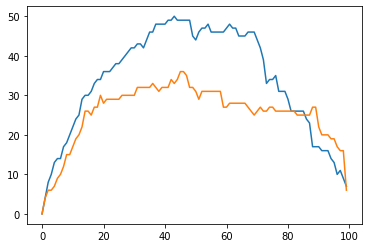

In [174]:
%%time
plot_flip_profile(2770)
plot_flip_profile(2840)
